In [1]:
import arviz as az
import numpyro
from numpyro.infer import Predictive, log_likelihood
import jax
import jax.random as random
import jax.numpy as jnp
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

# Add ../code to PYTHON_PATH
sys.path.insert(0, "../code")
import bnns.model_configs
from datasets.synthetic import SyntheticDataset
from datasets.uci import UCIDataset, dataset_names, load_standard_splits

/home/rasmuslovstad/Programs/assignments/thesis/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_names = [name for name in dir(bnns.model_configs)]
models = [getattr(bnns.model_configs, name) for name in model_names]
#datasets = [SyntheticDataset()] + [UCIDataset(name) for name in dataset_names]
datasets = [SyntheticDataset()]
dataset_names = [dataset.__class__.__name__ for dataset in datasets]

In [3]:
# Adjust as needed
SAMPLE_PATH = "../samples/2025-02-12T11:57:47.487059"
SAMPLE_PATH = SAMPLE_PATH + "/HMC"
DATASET = "SyntheticDataset"
SEED = 10


# Load samples
d_ind = dataset_names.index(DATASET)
dataset = datasets[d_ind]
model_names_in_folder = [name.split(".")[0] for name in os.listdir(f"{SAMPLE_PATH}/{dataset.dataset_name}") if name.endswith(".nc")]
az_datas = [az.from_netcdf(f"{SAMPLE_PATH}/{dataset.dataset_name}/{model_name}.nc") for model_name in model_names_in_folder]

# ESS per layer

array([[<Axes: title={'center': 'w0\n0, 0'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <Axes: title={'center': 'w0\n0, 1'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <Axes: title={'center': 'w0\n0, 2'}, xlabel='Quantile', ylabel='ESS for small intervals'>],
       [<Axes: title={'center': 'w0\n0, 3'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <Axes: title={'center': 'w0\n0, 4'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <Axes: >]], dtype=object)

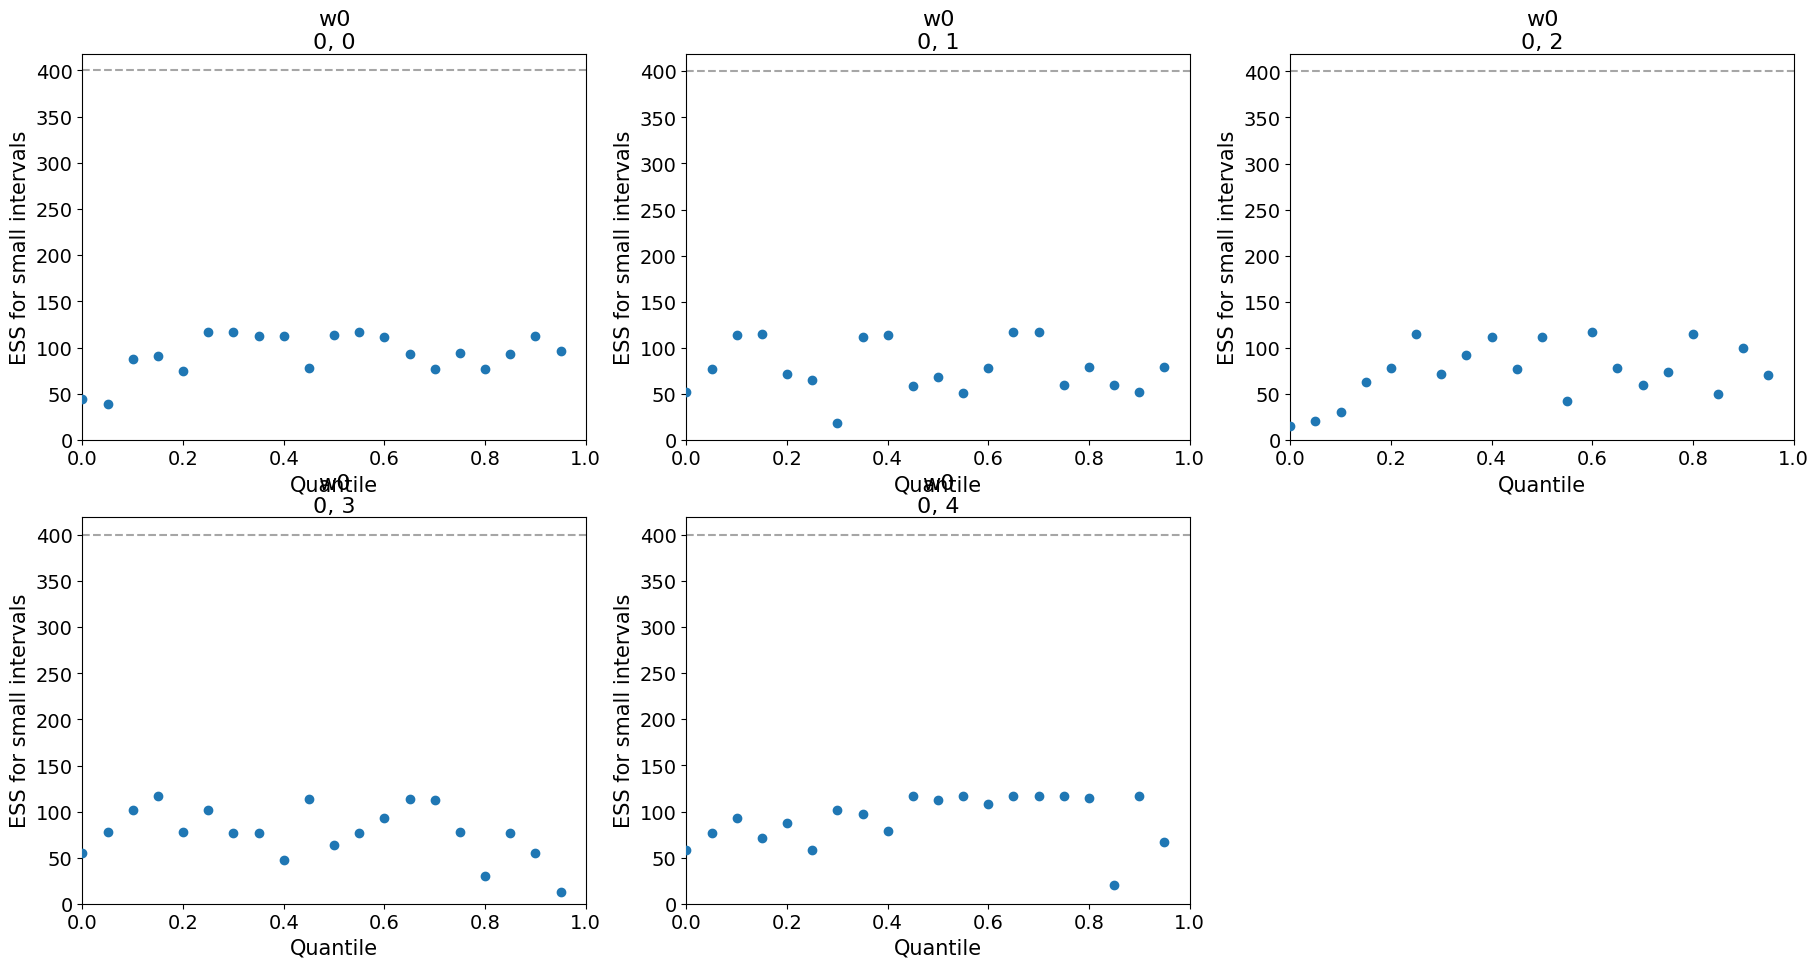

In [26]:
az.plot_ess(az_datas[1], var_names=["w0"])

# $\hat{r}$ and split-$\hat{r}$
Only relevant when $n_{chains} > 1$

In [8]:
az.rhat(az_datas[0], method="split")

arviz - WARNING - Shape validation failed: input_shape: (1, 100), minimum_shape: (chains=2, draws=4)


<xarray.Dataset> Size: 632B
Dimensions:   (b0_dim_0: 5, b1_dim_0: 5, b2_dim_0: 1, w0_dim_0: 1, w0_dim_1: 5,
               w1_dim_0: 5, w1_dim_1: 5, w2_dim_0: 5, w2_dim_1: 1)
Coordinates:
  * b0_dim_0  (b0_dim_0) int64 40B 0 1 2 3 4
  * b1_dim_0  (b1_dim_0) int64 40B 0 1 2 3 4
  * b2_dim_0  (b2_dim_0) int64 8B 0
  * w0_dim_0  (w0_dim_0) int64 8B 0
  * w0_dim_1  (w0_dim_1) int64 40B 0 1 2 3 4
  * w1_dim_0  (w1_dim_0) int64 40B 0 1 2 3 4
  * w1_dim_1  (w1_dim_1) int64 40B 0 1 2 3 4
  * w2_dim_0  (w2_dim_0) int64 40B 0 1 2 3 4
  * w2_dim_1  (w2_dim_1) int64 8B 0
Data variables:
    b0        (b0_dim_0) float64 40B nan nan nan nan nan
    b1        (b1_dim_0) float64 40B nan nan nan nan nan
    b2        (b2_dim_0) float64 8B nan
    w0        (w0_dim_0, w0_dim_1) float64 40B nan nan nan nan nan
    w1        (w1_dim_0, w1_dim_1) float64 200B nan nan nan nan ... nan nan nan
    w2        (w2_dim_0, w2_dim_1) float64 40B nan nan nan nan nan

# Model Comparison
Using Pareto-smoothed EPLD (by $\texttt{arviz.compare}$)

In [9]:
compare_dict = {}
for name, az_data in zip(model_names_in_folder,az_datas):
    compare_dict[name] = az_data
comparison = az.compare(compare_dict)

/home/rasmuslovstad/Programs/assignments/thesis/.venv/lib64/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.50 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/rasmuslovstad/Programs/assignments/thesis/.venv/lib64/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.50 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.wa

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

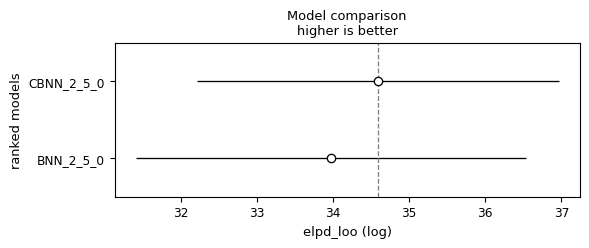

In [10]:
az.plot_compare(comparison)

/home/rasmuslovstad/Programs/assignments/thesis/.venv/lib64/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.50 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/rasmuslovstad/Programs/assignments/thesis/.venv/lib64/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.50 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.wa

<Axes: title={'center': 'BNN_2_5_0 - CBNN_2_5_0'}, ylabel='ELPD difference'>

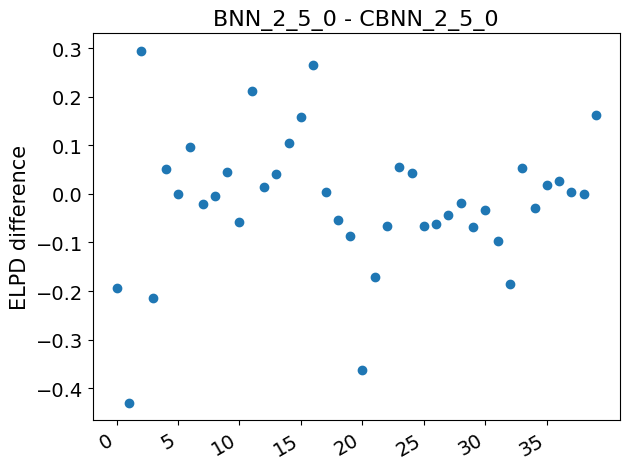

In [11]:
az.plot_elpd(compare_dict, xlabels=True)

# Synthetic data evaluation

BNN_2_5_0 (1, 100, 500, 1)
(1, 100, 500, 1)
CBNN_2_5_0 (1, 100, 500, 1)
(1, 100, 500, 1)


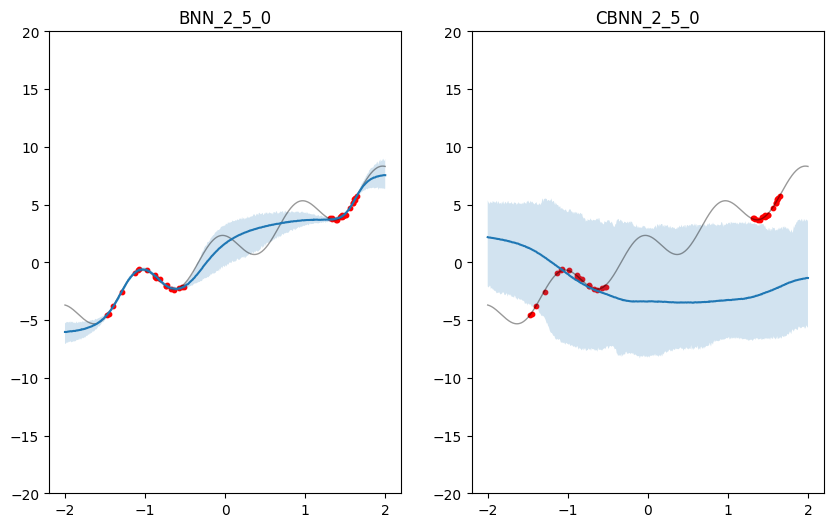

In [4]:
dataset = SyntheticDataset()
key = jax.random.PRNGKey(SEED)
keys = jax.random.split(key, len(model_names_in_folder))

fig, axs = plt.subplots(ncols=len(az_datas), figsize=(len(az_datas)*5, 6))
axs = axs.ravel()

for i, (model_name, az_data) in enumerate(zip(model_names_in_folder, az_datas)):
    ax = axs[i]
    model = models[model_names.index("_".join(model_name.split("_")[:-1]))]
    predictive = Predictive(model, posterior_samples=az_data.to_dict()["posterior"], return_sites=["y"], batch_ndims=2, parallel=True)
    predicted_ys = predictive(
            keys[i], 
            X=dataset.X_true.reshape(-1, 1),
            y=None, 
            D_Y=1,
            sigma=jnp.array(dataset.noise_level)
            )["y"]
    print(model_name, predicted_ys.shape)
    y_mean = predicted_ys.mean(axis=(0,1,3))
    y_bot_95 = jnp.percentile(predicted_ys, 5, axis=(1), method="nearest").mean(axis=(0,2))
    y_top_95 = jnp.percentile(predicted_ys, 95, axis=(1), method="nearest").mean(axis=(0,2))
    ax.plot(dataset.X_true, dataset.y_true, lw=1, c="black", alpha=0.4)
    ax.scatter(dataset.X_train, dataset.y_train, c="red", s=10)
    ax.set_ylim(-20, 20)
    print(predicted_ys.shape)
    ax.plot(
        dataset.X_true, 
        predicted_ys.mean(axis=(0,1,3)), 
        label=model_name
        )
    ax.fill_between(
        dataset.X_true, 
        y_bot_95, 
        y_top_95, 
        alpha=0.2
    )
    ax.set_title(model_name)
plt.show()

In [134]:
# Amont of parameters in middle layer of BNN, 100 deep
az_datas[2].to_dict()["posterior"]["w1"].size

50000000

# UCI Benchmark table (similar to Table 2 in Stein paper)

In [37]:
rows = []
key = jax.random.PRNGKey(SEED)
dataset_keys = jax.random.split(key, len(os.listdir(SAMPLE_PATH)))
for key, dataset_name in zip(dataset_keys, os.listdir(SAMPLE_PATH)):
    if not os.path.isdir(os.path.join(SAMPLE_PATH, dataset_name)):
        continue
    model_keys = jax.random.split(key, len(os.listdir(os.path.join(SAMPLE_PATH, dataset_name))))
    if dataset_name in dataset_names:
        dataset = UCIDataset(dataset_name)
        for key, file_name in zip(model_keys, os.listdir(os.path.join(SAMPLE_PATH, dataset_name))):
            if file_name[-3:] == ".nc":
                model_key = key
                model_name = "_".join(file_name.split("_")[:-1])
                model = bnns.model_configs.__dict__[model_name]
                split_ind = int(file_name.split("_")[-1].split(".")[0])
                az_data = az.from_netcdf(os.path.join(SAMPLE_PATH, dataset_name, file_name))
                samples = az_data.to_dict()["posterior"]
                splits = load_standard_splits(True)[dataset_name]
                split = splits[split_ind]["te"]
                test_X = dataset.data[split][:, :-1]
                test_y = dataset.data[split][:, -1]
                nll = -log_likelihood(model, samples, X=test_X, y=test_y, batch_ndims=2, parallel=True)["y"]
                predictive = Predictive(model, posterior_samples=samples, return_sites=["y"], batch_ndims=2, parallel=True)
                predicted_ys = predictive(model_key, X=test_X, y=None, D_Y=1)["y"]
                rmse = jnp.sqrt(((test_y - predicted_ys)**2).mean())
                rows.append({"dataset": dataset_name, "model": model_name, "split": split_ind, "nll": nll.mean(), "rmse": rmse})
df = pd.DataFrame(rows)

In [38]:
df.groupby(["dataset", "model"]).mean()

,,split,nll,rmse
dataset,model,,,
boston-housing,UCI_BNN_2_50,0.0,83.977463,10.952462


In [34]:
dataset.data[splits[1]["tr"]][:,:-1].std(0).mean()

Array(1.0077528, dtype=float32)